In [50]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv
data=pd.read_csv('gp.csv')
train=data[0:60].copy()
train=train.sort_index(by=['input'],ascending=True)

test=data[60:120].copy()
test=test.sort_index(by=['input'],ascending=True)
train_size=int(train.size/2)
test_size=int(test.size/2)
beta_inv=1

C:\Users\ben huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys
C:\Users\ben huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  # Remove the CWD from sys.path while we load stuff.


In [51]:
def GP_kernel(xn,xm,theta0,theta1,theta2,theta3):
    term1=theta0*math.exp(-0.5*theta1*(xn-xm).dot((xn-xm).T))
    term2=theta2
    term3=theta3*xn.dot(xm.T)
    return term1+term2+term3
def delta(n,m):
    if n==m:
        return 1
    else:
        return 0
def GP_prior_cov(train , train_size , beta_inv , theta0 , theta1 , theta2 , theta3):
    cov_matrix=np.ones((train_size,train_size))
    for i in range(train_size):
        for j in range(train_size):
            xn=np.ones((1,1))
            xn[0][0]=train.iloc[i][0]
            xm=np.ones((1,1))
            xm[0][0]=train.iloc[j][0]
            cov_matrix[i][j]=GP_kernel(xn,xm,theta0,theta1,theta2,theta3)+beta_inv*delta(i,j)
    return cov_matrix
def KandC(train , train_size , beta_inv , theta0 , theta1 , theta2 , theta3 ,new_data):
    k=np.ones((train_size,1))
    xn=np.ones((1,1))
    xm=np.ones((1,1))
    for i in range(train_size):
        xn[0][0]=train.iloc[i][0]
        xm[0][0]=new_data
        k[i][0]=GP_kernel(xn,xm,theta0,theta1,theta2,theta3)
    xn[0][0]=new_data
    xm[0][0]=new_data
    c=GP_kernel(xn,xm,theta0,theta1,theta2,theta3)+beta_inv
    return k,c
def GP_post_distribution( train ,train_size, beta_inv , theta0 , theta1 , theta2 , theta3  ,new_data_v):
    m_v  =np.ones((new_data_v.size))
    var_v=np.ones((new_data_v.size))
    CN=GP_prior_cov(train,train_size,beta_inv,theta0,theta1,theta2,theta3)
    CN_inv=inv(CN)
    t_vector=np.ones((train_size,1))
    for i in range(train_size):
        t_vector[i][0]=train.iloc[i][1]
    for i in range(new_data_v.size):
        k,c=KandC(train , train_size , beta_inv , theta0 , theta1 , theta2 , theta3 ,new_data_v[i])
        m_v[i]   =(k.T).dot(CN_inv).dot(t_vector)
        var_v[i] =c-(k.T).dot(CN_inv).dot(k)
    return m_v,var_v

In [52]:
theta0=1 ; theta1=4 ;theta2=0 ;theta3=0
test_fun  =np.ones((5))
test_fun[0]=0 ;test_fun[1]=0.1 ;test_fun[2]=0.2 ;test_fun[3]=0.3 ;test_fun[4]=0.4 ;
m,var=GP_post_distribution(train ,train_size, beta_inv , theta0 , theta1 , theta2 , theta3  ,test_fun)
m

array([3.37610204, 3.72925344, 4.01407987, 4.19978071, 4.25386223])

In [53]:
train_p=train.values
train_p=np.sort(train_p, axis=1)

In [54]:
train_p_data=np.ones((train_size))
train_p_target=np.ones((train_size))
test_p_data=np.ones((test_size))
test_p_target=np.ones((test_size))
for i in range(train_size):
    train_p_data[i]=train.iloc[i][0]
    train_p_target[i]=train.iloc[i][1]
for i in range(test_size):
    test_p_data[i]=test.iloc[i][0]
    test_p_target[i]=test.iloc[i][1]

In [55]:
print("process 1")
theta0=1 ; theta1=4 ;theta2=0 ;theta3=0
train_predict1_m,train_predict1_var=GP_post_distribution(train ,
                                                         train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,train_p_data)
print("process 2")
theta0=0 ; theta1=0 ;theta2=0 ;theta3=1
train_predict2_m,train_predict2_var=GP_post_distribution(train ,
                                                         train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,train_p_data)
print("process 3")
theta0=1 ; theta1=4 ;theta2=0 ;theta3=5
train_predict3_m,train_predict3_var=GP_post_distribution(train ,
                                                         train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,train_p_data)
print("process 4")
theta0=1 ; theta1=64 ;theta2=10 ;theta3=0
train_predict4_m,train_predict4_var=GP_post_distribution(train ,
                                                         train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,train_p_data)
    
train_predict1_std=1*np.sqrt(train_predict1_var)
train_predict2_std=1*np.sqrt(train_predict2_var)
train_predict3_std=1*np.sqrt(train_predict3_var)
train_predict4_std=1*np.sqrt(train_predict4_var)

process 1
process 2
process 3
process 4


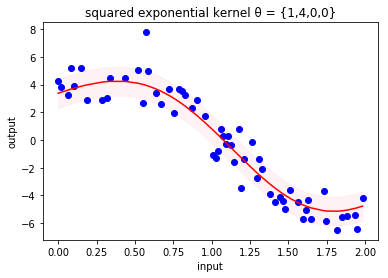

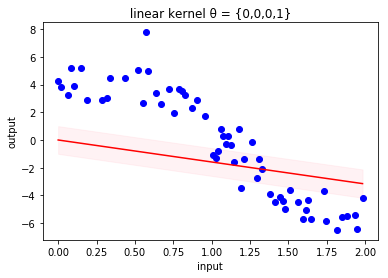

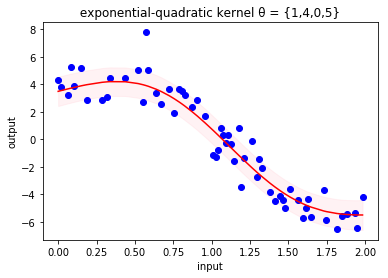

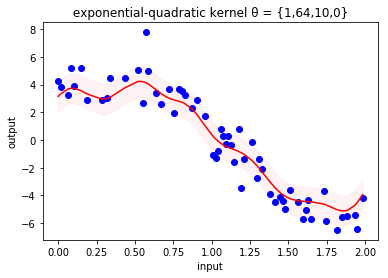

In [65]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('input')
plt.ylabel('output')
plt.title('squared exponential kernel θ = {1,4,0,0}')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(train_p_data,train_predict1_m,'-',color='red')
plt.fill_between(train_p_data,train_predict1_m-train_predict1_std,train_predict1_m+train_predict1_std,color='pink',alpha=0.2)

plt.figure()
plt.xlabel('input')
plt.ylabel('output')
plt.title(' linear kernel θ = {0,0,0,1} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(train_p_data,train_predict2_m,'-',color='red')
plt.fill_between(train_p_data,train_predict2_m-train_predict2_std,train_predict2_m+train_predict2_std,color='pink',alpha=0.2)

plt.figure()
plt.xlabel('input')
plt.ylabel('output')
plt.title(' exponential-quadratic kernel θ = {1,4,0,5} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(train_p_data,train_predict3_m,'-',color='red')
plt.fill_between(train_p_data,train_predict3_m-train_predict3_std,train_predict3_m+train_predict3_std,color='pink',alpha=0.2)

plt.figure()
plt.xlabel('input')
plt.ylabel('output')
plt.title(' exponential-quadratic kernel θ = {1,64,10,0} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(train_p_data,train_predict4_m,'-',color='red')
plt.fill_between(train_p_data,train_predict4_m-train_predict4_std,train_predict4_m+train_predict4_std,color='pink',alpha=0.2)



In [59]:
erms1=0 ; erms2=0 ; erms3=0 ; erms4=0
for i in range(train_size):
    erms1=erms1+(train_predict1_m[i]-train_p_target[i])**2
    erms2=erms2+(train_predict2_m[i]-train_p_target[i])**2
    erms3=erms3+(train_predict3_m[i]-train_p_target[i])**2
    erms4=erms4+(train_predict4_m[i]-train_p_target[i])**2
erms1=erms1/train_size ; erms2=erms2/train_size ; erms3=erms3/train_size ; erms4=erms4/train_size
erms1=(erms1)**0.5     ; erms2=(erms2)**0.5     ; erms3=(erms3)**0.5     ; erms4=(erms4)**0.5
print("for squared exponential   kernel θ = {1, 4, 0,0} ,training erms=",erms1)
print("for linear                kernel θ = {0, 0, 0,1} ,training erms=",erms2)
print("for exponential-quadratic kernel θ = {1, 4, 0,5} ,training erms=",erms3)
print("for exponential-quadratic kernel θ = {1,64,10,0} ,training erms=",erms4)

for squared exponential   kernel θ = {1, 4, 0,0} ,training erms= 1.0859078251089593
for linear                kernel θ = {0, 0, 0,1} ,training erms= 3.375501292224377
for exponential-quadratic kernel θ = {1, 4, 0,5} ,training erms= 1.0768359724266972
for exponential-quadratic kernel θ = {1,64,10,0} ,training erms= 1.0606651654811616


In [60]:
print("process 1")
theta0=1 ; theta1=4 ;theta2=0 ;theta3=0
test_predict1_m,test_predict1_var=GP_post_distribution(  train 
                                                         ,train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,test_p_data)
print("process 2")
theta0=0 ; theta1=0 ;theta2=0 ;theta3=1
test_predict2_m,test_predict2_var=GP_post_distribution(  train 
                                                         ,train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,test_p_data)
print("process 3")
theta0=1 ; theta1=4 ;theta2=0 ;theta3=5
test_predict3_m,test_predict3_var=GP_post_distribution(  train 
                                                         ,train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,test_p_data)
print("process 4")
theta0=1 ; theta1=64 ;theta2=10 ;theta3=0
test_predict4_m,test_predict4_var=GP_post_distribution(  train 
                                                         ,train_size
                                                         ,beta_inv
                                                         ,theta0,theta1,theta2,theta3
                                                         ,test_p_data)
    
test_predict1_std=1*np.sqrt(test_predict1_var)
test_predict2_std=1*np.sqrt(test_predict2_var)
test_predict3_std=1*np.sqrt(test_predict3_var)
test_predict4_std=1*np.sqrt(test_predict4_var)




erms1=0 ; erms2=0 ; erms3=0 ; erms4=0
for i in range(train_size):
    erms1=erms1+(test_predict1_m[i]-test_p_target[i])**2
    erms2=erms2+(test_predict2_m[i]-test_p_target[i])**2
    erms3=erms3+(test_predict3_m[i]-test_p_target[i])**2
    erms4=erms4+(test_predict4_m[i]-test_p_target[i])**2
erms1=erms1/test_size ; erms2=erms2/test_size ; erms3=erms3/test_size ; erms4=erms4/test_size
erms1=(erms1)**0.5     ; erms2=(erms2)**0.5     ; erms3=(erms3)**0.5     ; erms4=(erms4)**0.5
print("for squared exponential   kernel θ = {1, 4, 0,0} ,testing erms=",erms1)
print("for linear                kernel θ = {0, 0, 0,1} ,testing erms=",erms2)
print("for exponential-quadratic kernel θ = {1, 4, 0,5} ,testing erms=",erms3)
print("for exponential-quadratic kernel θ = {1,64,10,0} ,testing erms=",erms4)

process 1
process 2
process 3
process 4
for squared exponential   kernel θ = {1, 4, 0,0} ,testing erms= 1.016759920881014
for linear                kernel θ = {0, 0, 0,1} ,testing erms= 3.8497751148340518
for exponential-quadratic kernel θ = {1, 4, 0,5} ,testing erms= 1.0576270328084991
for exponential-quadratic kernel θ = {1,64,10,0} ,testing erms= 1.2433457860457002


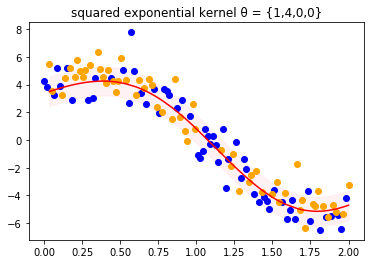

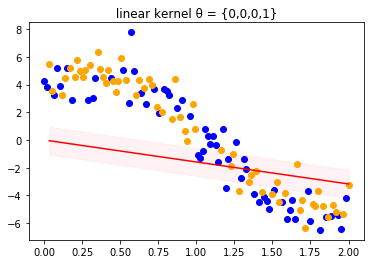

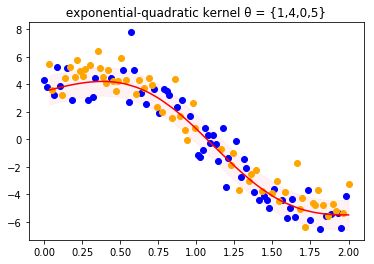

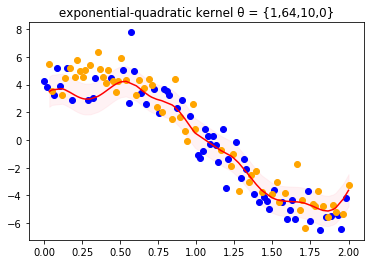

In [68]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('squared exponential kernel θ = {1,4,0,0}')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(test_p_data[:test_size],test_p_target[:test_size],'or',color='orange')
plt.plot(test_p_data,test_predict1_m,'-',color='red')
plt.fill_between(test_p_data,test_predict1_m-test_predict1_std,test_predict1_m+test_predict1_std,color='pink',alpha=0.2)



plt.figure()
plt.title(' linear kernel θ = {0,0,0,1} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(test_p_data[:test_size],test_p_target[:test_size],'or',color='orange')
plt.plot(test_p_data,test_predict2_m,'-',color='red')
plt.fill_between(test_p_data,test_predict2_m-test_predict2_std,test_predict2_m+test_predict2_std,color='pink',alpha=0.2)

plt.figure()
plt.title(' exponential-quadratic kernel θ = {1,4,0,5} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(test_p_data[:test_size],test_p_target[:test_size],'or',color='orange')
plt.plot(test_p_data,test_predict3_m,'-',color='red')
plt.fill_between(test_p_data,test_predict3_m-test_predict3_std,test_predict3_m+test_predict3_std,color='pink',alpha=0.2)

plt.figure()
plt.title(' exponential-quadratic kernel θ = {1,64,10,0} ')
plt.plot(train_p_data[:train_size],train_p_target[:train_size],'or',color='blue')
plt.plot(test_p_data[:test_size],test_p_target[:test_size],'or',color='orange')
plt.plot(test_p_data,test_predict4_m,'-',color='red')
plt.fill_between(test_p_data,test_predict4_m-test_predict4_std,test_predict4_m+test_predict4_std,color='pink',alpha=0.2)